### Import Packages

In [195]:
import numpy as np
import itertools
import copy
from IPython import display
from matplotlib import pyplot as plt
import pretty_midi
import pickle
from music21 import *
import sys
np.set_printoptions(threshold=sys.maxsize)

### Import Dataset and Network

In [3]:
with open("./JSB-Chorales-dataset/jsb-chorales-8th.pkl", "rb") as p:
    data = pickle.load(p, encoding="latin1")

In [4]:
import sys
import importlib
# sys.path.append("/Users/clementjin/Library/CloudStorage/OneDrive-MagdalenCollegeSchool/Machine Learning/my-code/neural-networks-and-deep-learning/my-code")
import my_mnist_network
importlib.reload(my_mnist_network)


<module 'my_mnist_network' from '/Users/clementjin/Library/CloudStorage/OneDrive-MagdalenCollegeSchool/Machine Learning/my-code/music_v1/music_v1/my_mnist_network.py'>

## Utility Functions

#### Network Constants

In [182]:
inputs = 32
outputs = 32

exclude_low_notes = 30 # we exclude the bottom 20 notes from being considered.

notes_per_beat = 4

pitch_length = 46
pitch_offset=36

duration_length = 8
max_duration = duration_length

onehot_length = pitch_length + duration_length
total_length = pitch_length + duration_length

In [166]:
net = my_mnist_network.Network([inputs*total_length, 500, 500, 500, outputs*total_length])

### Converting between OneHot and Integer representations

In [89]:
class NoteEmbedding:

    ONE_HOT_LENGTH = 46
    OFFSET = 36 # i.e., index + offset = MIDI note value

    @classmethod
    def make_onehot(cls, line: list, transpose=True, pitch_length=pitch_length, pitch_offset=pitch_offset, duration_length=duration_length):
        """input: a list of NoteEmbeddings. Each tuple is of the form (MIDI pitch: int, quaver beats: int). converts a single top line melody into a single flattened array that is transposed. NB if a note is longer than `max_duration` then it will be truncated to duration=`max_duration`.
            Output form: [0, 0, 0, ..., 1 ...0, 0, 0, ... then duration part is 0, 0, 1, 0]. Note that index -1 is duration 1, index -2 is duration 2, etc."""
        onehots = np.array([])
        for note_embedding in line:
            note, duration = note_embedding.note_pitch, note_embedding.note_duration

            onehot_note = np.zeros(pitch_length + duration_length)

            # setting onehot bit for pitch
            index = int(note - pitch_offset)
            onehot_note[index] = 1

            # setting onehot bit for duration, indexing backwards
            duration = int(duration)
            if duration > max_duration:
                duration = max_duration
            index = duration
            onehot_note[-index] = 1

            onehots = np.append(onehots, onehot_note)

        if transpose:
            onehots = np.atleast_2d(onehots).T

        return onehots
    
    @classmethod
    def make_embedding(cls, line: np.array, transposed=True, pitch_length=46, pitch_offset=36, duration_length=max_duration):
        """converts a vertical onehot array of multiple notes into a list of NoteEmbedding objects."""

        # we always deal with the flattened version
        if transposed: 
            line = line.flatten()
        line = list(line)
    
        note_embeddings = []
        
        embedding_length = pitch_length + duration_length

        for i in range(0, len(line), embedding_length):
            # get pitch index
            note_index = line[i:i+pitch_length].index(1) # within the pitch section of our slice we look for the index of the value "1"
            note_value = note_index + pitch_offset

            # get duration index
            duration_index = line[i + pitch_length : i + embedding_length].index(1)
            duration_value = max_duration - duration_index

            # add to a NoteEmbedding object
            note = NoteEmbedding(note_value, duration_value)
            note_embeddings.append(note)

        note_embeddings = np.array(note_embeddings)
        return note_embeddings

    @classmethod
    def sum_to_one(cls, v):
        """make the values in an array sum to one"""
        total = sum(v)
        return v / total    
    
    def __init__(self, note_pitch : int, note_duration: int) -> None: 
        """note_pitch is the MIDI pitch, note_duration is how many QUARTERS of a beat the note is. e.g., 1 -> 1/4 of a beat, 2 -> 2/4 of a beat, etc. The embedding accomodates for durations of 1/4 -> `max_duration`/4. 
            NB. the duration can be fractional, e.g., 3.5, BUT when converting to onehot the decimal will be rounded DOWN. """
        self.note_pitch = note_pitch
        self.note_duration = note_duration
        self.onehot = NoteEmbedding.make_onehot([self])

    def increase_duration(self, amount=max_duration/notes_per_beat):
        self.note_duration += amount

        if self.note_duration > max_duration:
            self.note_duration = max_duration
            raise ValueError(f"pitch_duration exceeded the maximum of {max_duration}. Instead got duration of {self.note_duration + amount}.")

    def __repr__(self) -> str:
        return f"pitch: {self.note_pitch}; duration: {self.note_duration}"
    def __eq__(self, other) -> bool:
        return ((self.note_duration == other.note_duration) and (self.note_pitch == other.note_pitch)) 
        

my_notes = [NoteEmbedding(i, i % 4 + 1) for i in range(37, 60)]
my_note = my_notes[0]
# NoteEmbedding.make_onehot([NoteEmbedding(45, 7)])
# onehot = NoteEmbedding.make_onehot(my_notes)
# recovered = NoteEmbedding.make_embedding(onehot)
# my_note.increase_duration()

### Playing Generated Music

In [90]:
_SAMPLING_RATE = 16000.0

def display_audio(pm: pretty_midi.PrettyMIDI, seconds=200):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*int(_SAMPLING_RATE)]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [336]:
def create_pm(note_values, bpm=60, notes_per_beat=notes_per_beat, velocity=100):
    """note values is a column vector of note values."""

    pm = pretty_midi.PrettyMIDI()
    vocal_number = 54
    instrument = pretty_midi.Instrument(program = vocal_number)

    timestep = 60/(bpm * notes_per_beat)

    prev_notes = []

    last_time = 0
    for embedding in note_values:
        pitch = embedding.note_pitch
        while pitch < 30:
            pitch += 12
        note = pretty_midi.Note(velocity, pitch=pitch, start=last_time*timestep, end=(last_time+embedding.note_duration)*timestep)
        instrument.notes.append(note)

        last_time += embedding.note_duration # now the next note starts when the current note finishes

    # for time, note in enumerate(note_values):
    #     note = pretty_midi.Note(velocity, pitch=note.note_pitch, start=time*timestep, end=(time+note.note_duration)*timestep)
    #     instrument.notes.append(note)

    pm.instruments.append(instrument)
    return pm


In [115]:
def play_notes(note_values, bpm=180, notes_per_beat=notes_per_beat, velocity=100, show=True):
    if show:
        stream1 = make_stream(note_values)
        stream1.show()
    return display_audio(create_pm(note_values=note_values, bpm=bpm, notes_per_beat=notes_per_beat, velocity=velocity))

In [225]:
def make_stream(note_values):
    stream1= stream.Stream()
    for single_note in note_values:
        my_note = note.Note(single_note.note_pitch)
        my_note.quarterLength = 0.5*single_note.note_duration
        stream1.append(my_note)
    return stream1

The average length of each chorale is 120

In [94]:
# Calculating the highest and lowest note values
maximum = 0
minimum = 100
for set in data.values():
    for chorale in set:
        for chord in chorale:
            try:
                if max(chord) > maximum:
                    maximum = max(chord)
                if min(chord) < minimum:
                    minimum = min(chord)
            except: # this only happens when the tuple is empyy
                pass # we exclude any chorale with a moment of silence
print(maximum, minimum) # outputs `81 36`, so 46 output neurones are required.

81 36


### Extract Top Lines from the Melodies

In [95]:
# we are only interested in the top line, i.e. the melody
top_lines = [[], [], []]


for top_line, dataset in zip(top_lines, data.values()):
    for chorale in dataset:
        
        # Generates sequences with redundant notes
        try:
            top_notes = [chord[0] for chord in chorale]
        except:
            pass # exclude chorales with empty chords
        
        # Make into non-redundant, duration featured NoteEmbedding Objects
        first_note = NoteEmbedding(note_pitch=top_notes[0], note_duration=1) # we add the first note to `notes` immediately
        notes = [first_note]
        top_notes = top_notes[1:] # now exclude that note

        for pitch in top_notes:
            last_pitch = notes[-1].note_pitch
            if pitch == last_pitch:

                try: # try to increase duration
                    notes[-1].increase_duration() 
                except ValueError: # if duration is already max, then start a new note with same pitch
                    notes.append(NoteEmbedding(note_pitch=pitch, note_duration=1)) 

            else:
                notes.append(NoteEmbedding(note_pitch=pitch, note_duration=1))
        
        top_line.append(notes)

top_test, top_train, top_validate = top_lines

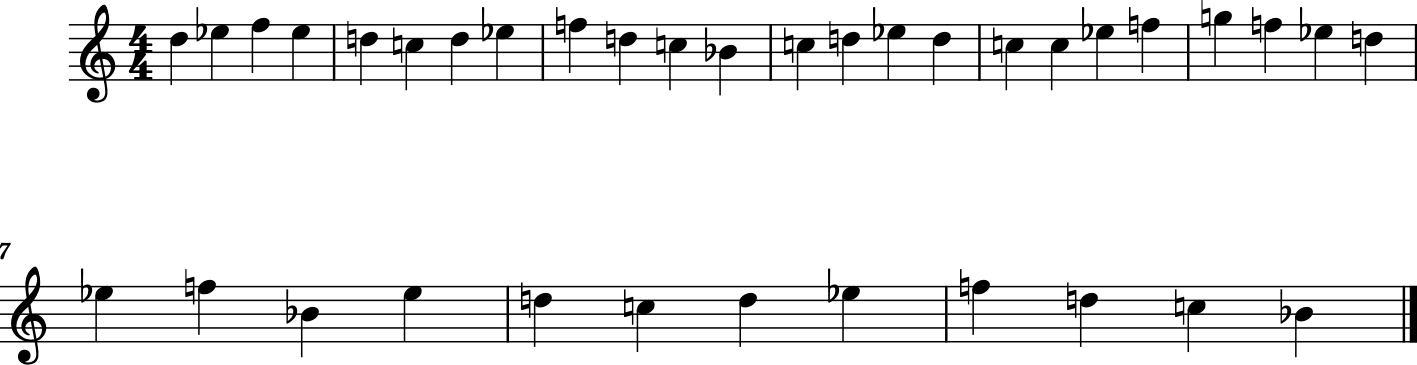

In [103]:
play_notes(top_train[0])

In [63]:
# the longest held notes in each chorlae of the dataset
[max(i, key=lambda x: x.note_duration) for j in top_lines for i in j]

# the longest held note in the entire dataset
max([max(i, key=lambda x: x.note_duration) for j in top_lines for i in j], key=lambda x: x.note_duration)

pitch: 77.0; duration: 49.0

### Generating pairs of input-target_output pairs for top notes

In [97]:
pairs = [[], [], []] # i.e. pairs of input-output tuples

for pair, top_line in zip(pairs, top_lines):
    for melody in top_line:

        length = len(melody)
        valid_pairs = length - (inputs + outputs) + 1
        for i in range(valid_pairs):
            # take a slice of the orignal melody
            x = np.array(melody[i : i + inputs]) # the inputs to the network
            y = np.array(melody[i + inputs : i + inputs + outputs]) # the target outputs have no overlap with the inputs. 
            
            x = NoteEmbedding.make_onehot(x)
            y = NoteEmbedding.make_onehot(y)

            pair.append((x, y))

test_data, train_data, validate_data = pairs

In [ ]:
play_notes(NoteEmbedding.make_embedding(train_data[0][1]))

### Extending the top line melody

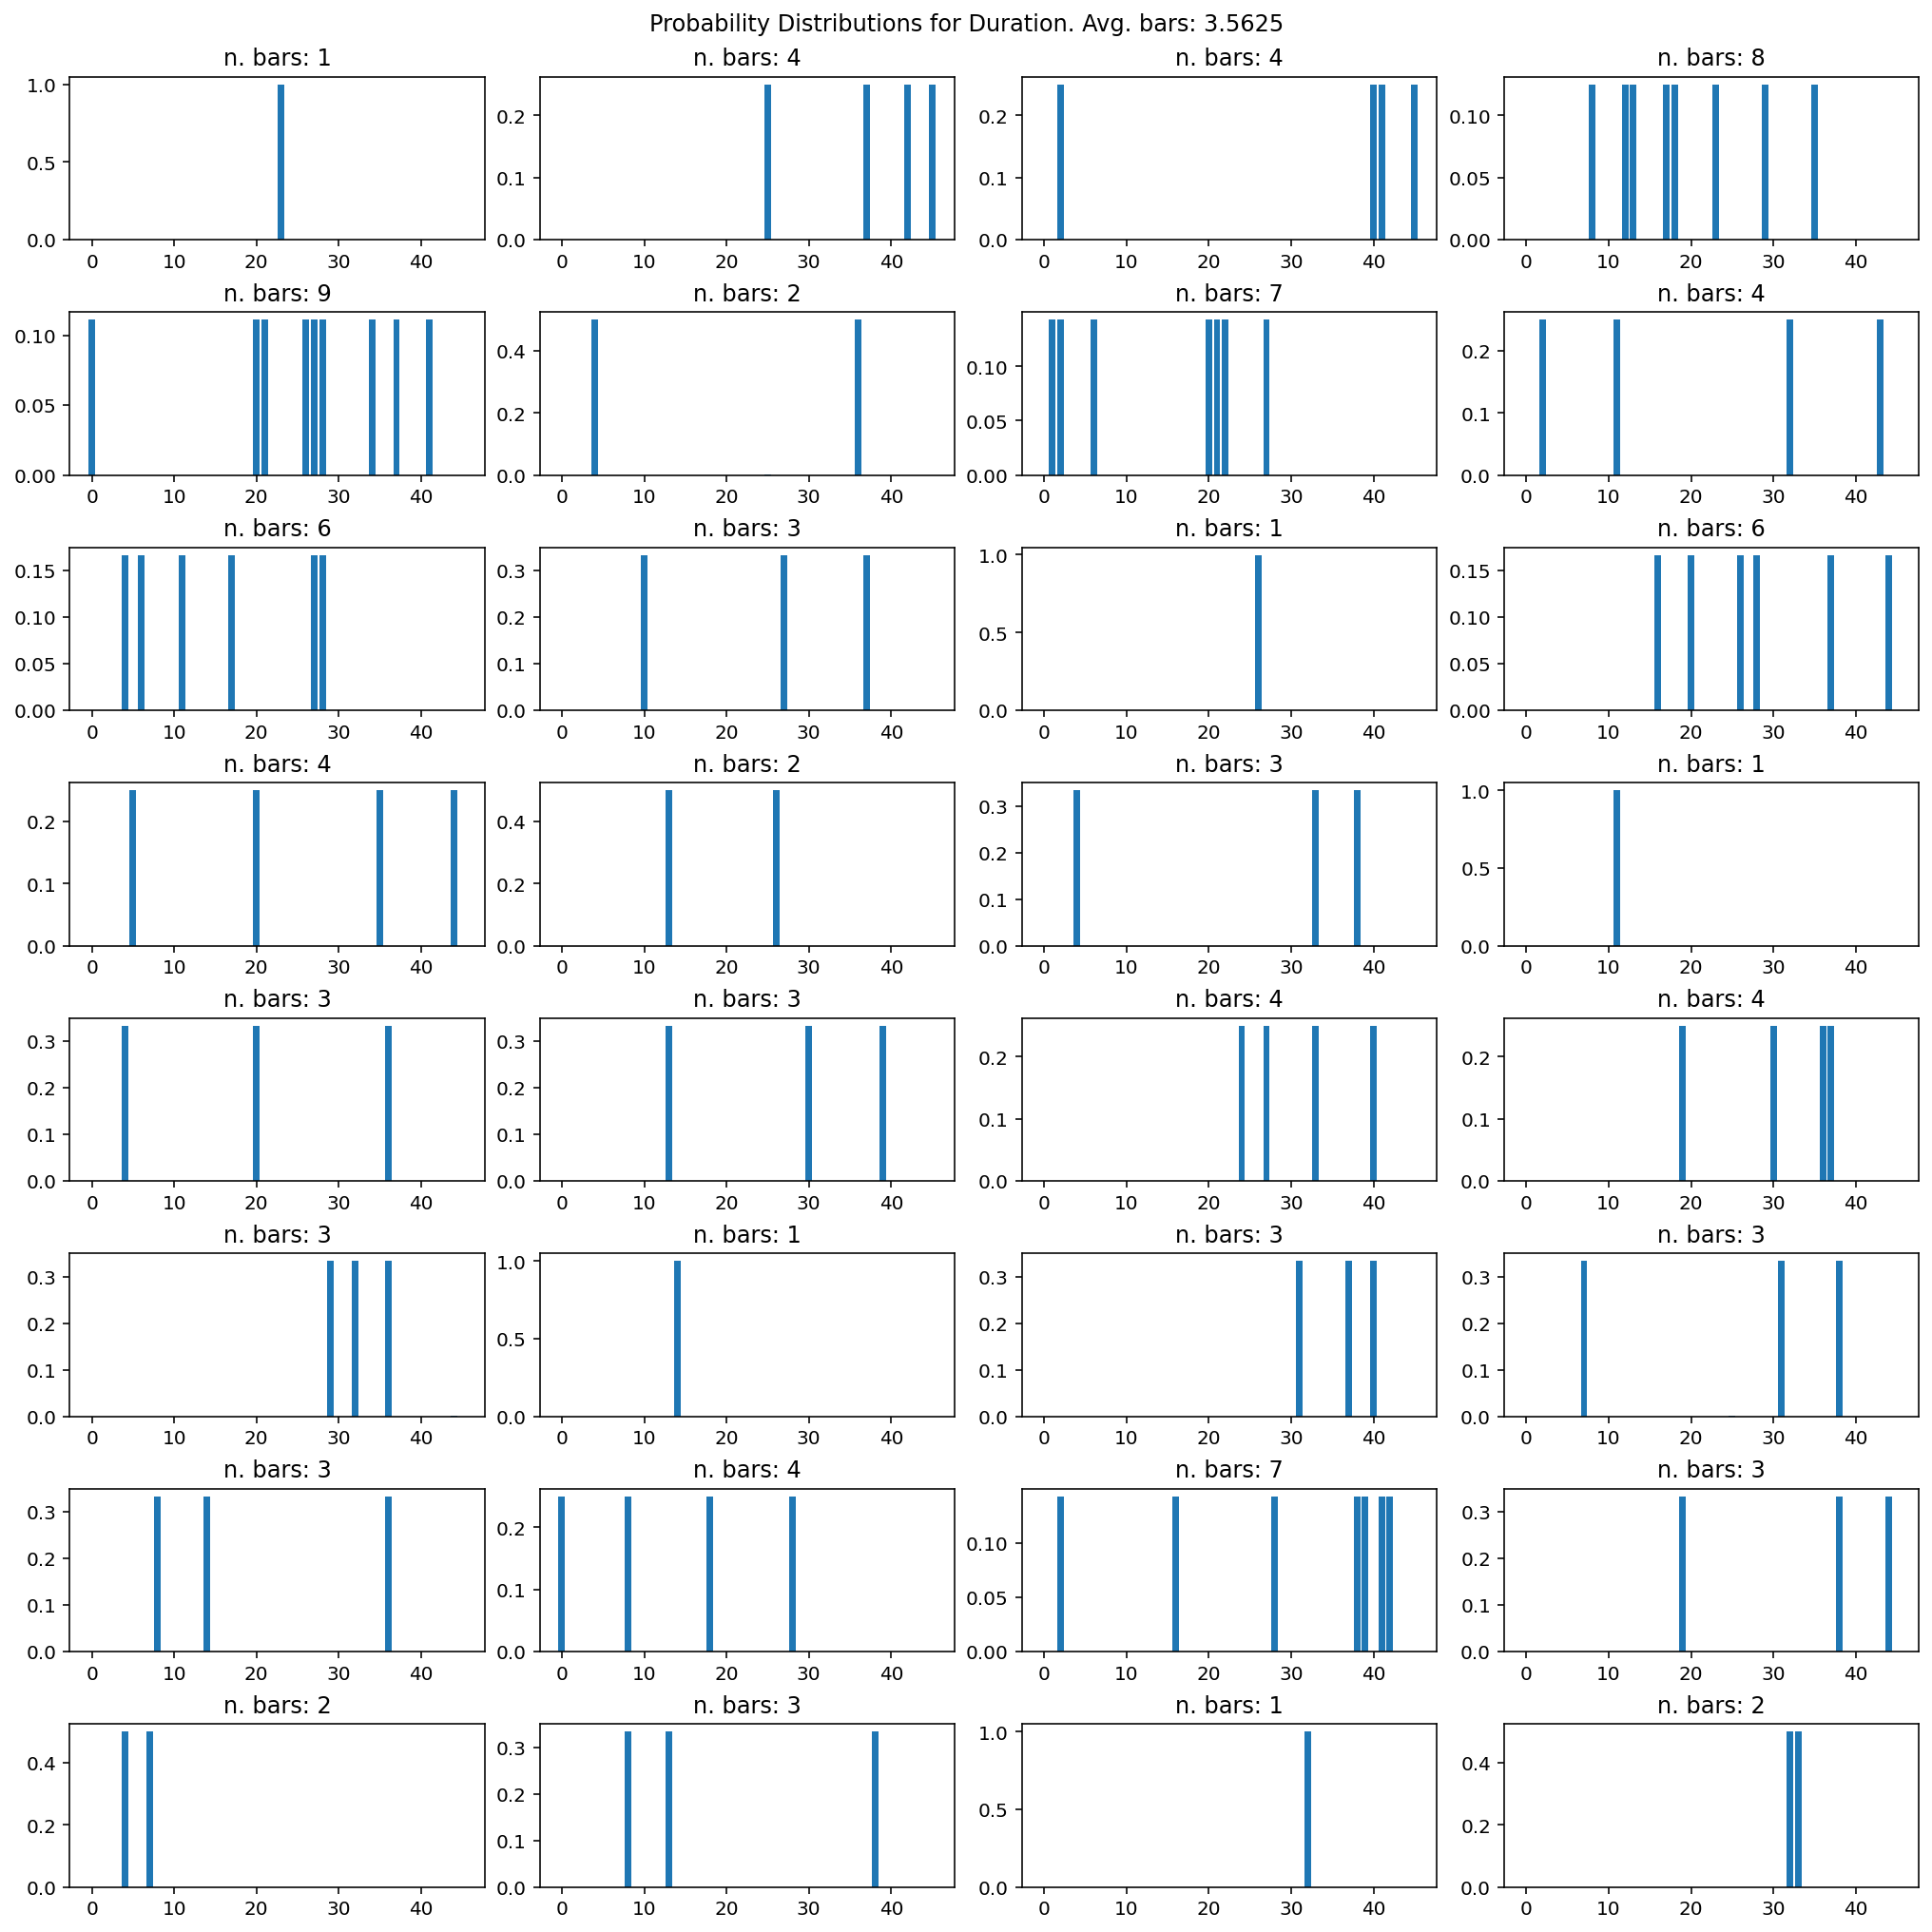

In [334]:
exclude_low_notes = 0
def extend_melody(input, plot=False):
    """input: 32 notes in one-hot representation and transposed vertically. output: the new 32 notes ONLY in ONEHOT representation, transposed."""
    required_length = inputs * onehot_length


    if not(required_length == input.shape[0]):
        print(f"WARNING: input of shape {input.shape}. Expected ({required_length}, 1). THE LAST {inputs*pitch_length} values of the array will be taken, instead of the entire thing. ")

    actual_melody = []
    
    net_input = input[-required_length:]
    net_output = net.feedforward(net_input) # the outputs are the probability distributions. 


    if plot:
        # plotting stuff
        plot_counter = 0
        fig = plt.figure(1, figsize=(14, 14), layout='constrained')
        fig.suptitle("Probability Distributions for Pitch")
        axs = fig.subplot_mosaic(np.arange(32).reshape(8, 4))

        # fig_dur = plt.figure(2, figsize=(14, 14), layout='constrained')
        # fig_dur.suptitle("Probability Distributions for Duration")
        # axs_dur = fig.subplot_mosaic(np.arange(32).reshape(8, 4))

        # bar counting
        total_bars = 0


    # selecting a note from the probability distrubtion
    for slice in range(0, required_length, onehot_length):

        # select note value from distribution
        note_values = np.arange(exclude_low_notes, pitch_length) + pitch_offset
        distribution = net_output[slice + exclude_low_notes: slice + pitch_length]
        distribution = NoteEmbedding.sum_to_one(distribution)
        distribution = distribution.flatten()

        # select note duration from distribution
        note_durations = np.arange(0, duration_length) + 1 # the possible note durations are 1, 2, 3 ... `duration_length`
        duration_dist = net_output[slice + pitch_length : slice + onehot_length] # the bits immediately after the ones that determine pitch
        duration_dist = NoteEmbedding.sum_to_one(duration_dist) 
        duration_dist = duration_dist.flatten()

        # choosing the note and duration
        duration_chosen = np.random.choice(note_durations, p=duration_dist)
        note_chosen = np.random.choice(note_values, p=distribution)
        embedding = NoteEmbedding(note_chosen, duration_chosen)

        if plot:
            axs[plot_counter].bar(np.arange(exclude_low_notes, 46), distribution)

            no_bars = np.sum(distribution >= 0.01)
            total_bars += no_bars
            axs[plot_counter].set_title(f"n. bars: {no_bars}")
            plot_counter += 1

        # if len(note_values) != len(distribution):
        #     print(slice, slice + pitch_length, len(net_output[slice:slice + pitch_length]))

        
        actual_melody.append(embedding)
    if plot:
        fig.suptitle(f"Probability Distributions for Duration. Avg. bars: {total_bars/outputs}")
        
    return NoteEmbedding.make_onehot(actual_melody)


n = 2
data = NoteEmbedding.make_embedding(train_data[n][0])
untrained = extend_melody(train_data[n][0], plot=True)
untrained = NoteEmbedding.make_embedding(untrained)
# play_notes(np.append(data, untrained))

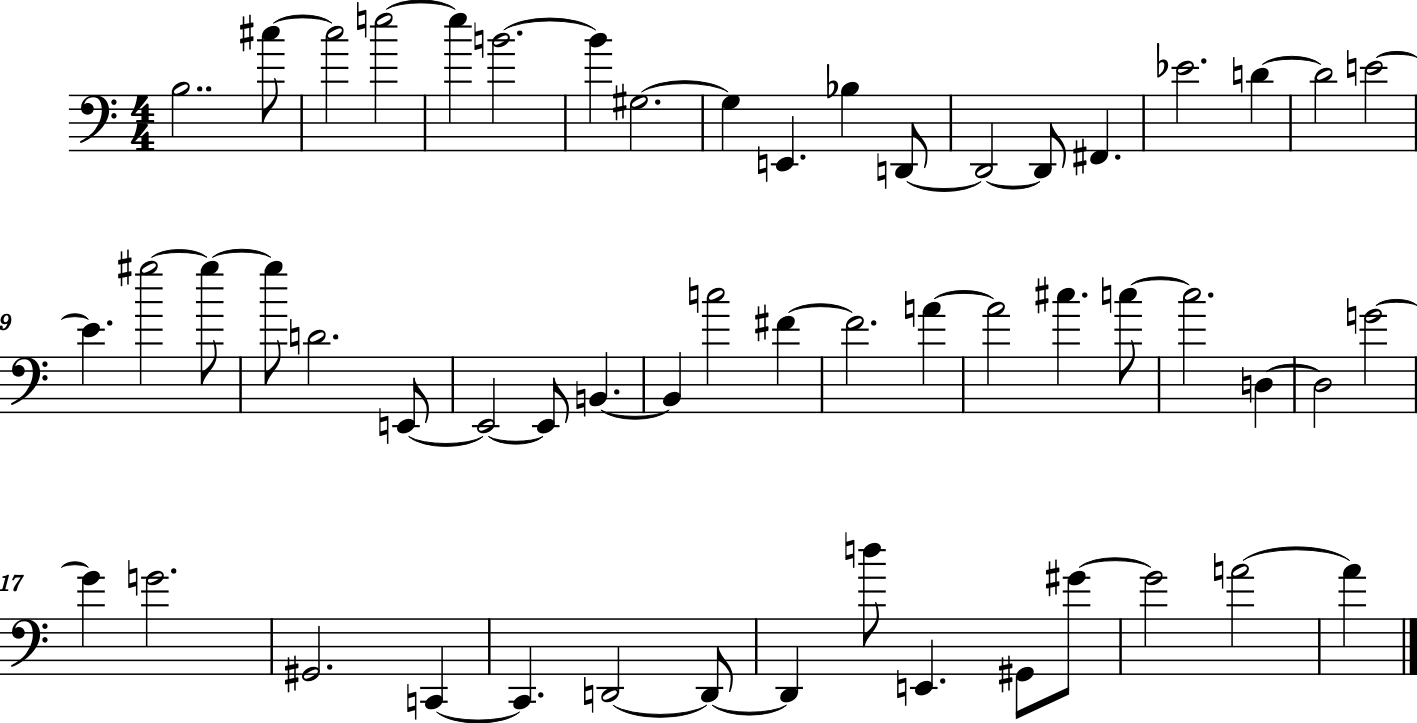

In [337]:
play_notes(untrained)

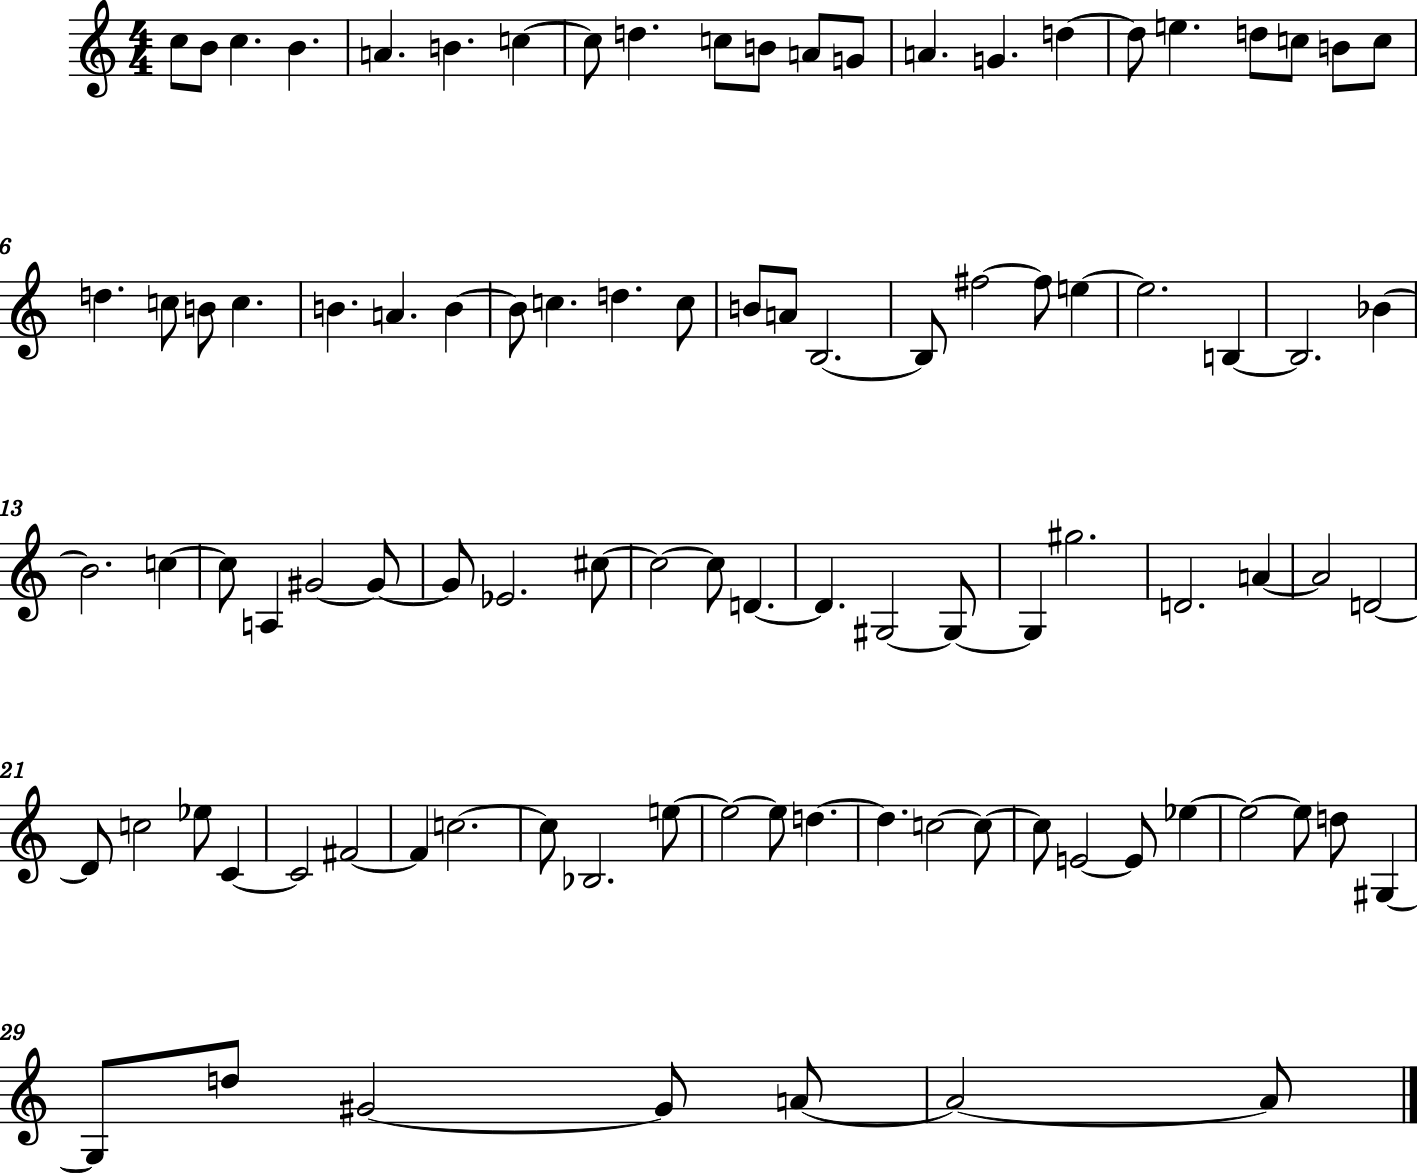

In [330]:
def extend_recursively(input, iterations):
    """input: 32 notes in ONEHOT representation, transposed. Output: those 32 notes plus the melody extended `iterations` times, in ONEHOT representation, transposed."""
    required_length = inputs * onehot_length
    
    melody = copy.deepcopy(input)
    for i in range(iterations):
        new_part = extend_melody(melody[-required_length:])
        melody = np.append(melody, new_part, axis=0)
    return melody


m = 2
untrained_2 = extend_recursively(train_data[m][0], 1)
untrained_2 = NoteEmbedding.make_embedding(untrained_2)
play_notes(untrained_2)
        

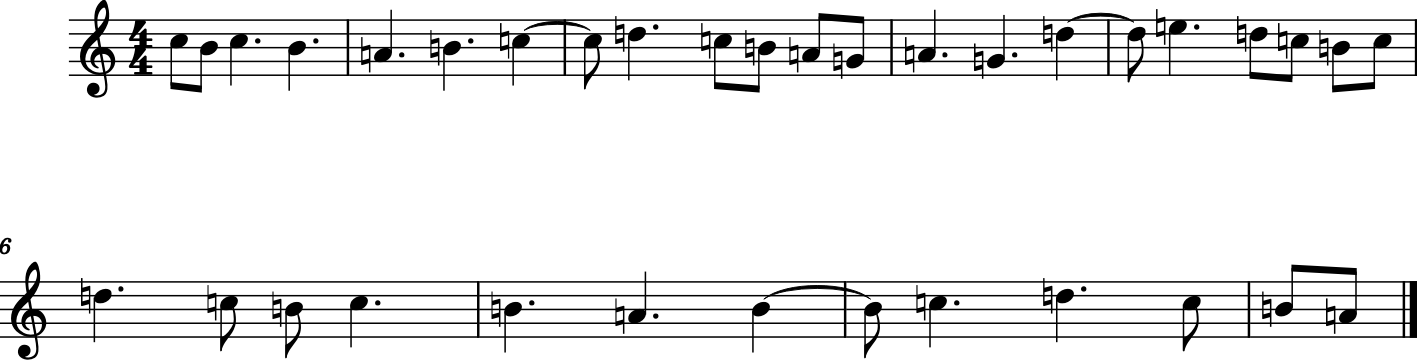

In [331]:
play_notes(NoteEmbedding.make_embedding(train_data[m][0]))

### Training the network

In [326]:
net.load("parameters")

0 epochs complete.
Average Cost in epoch 0: [95.0089038] 


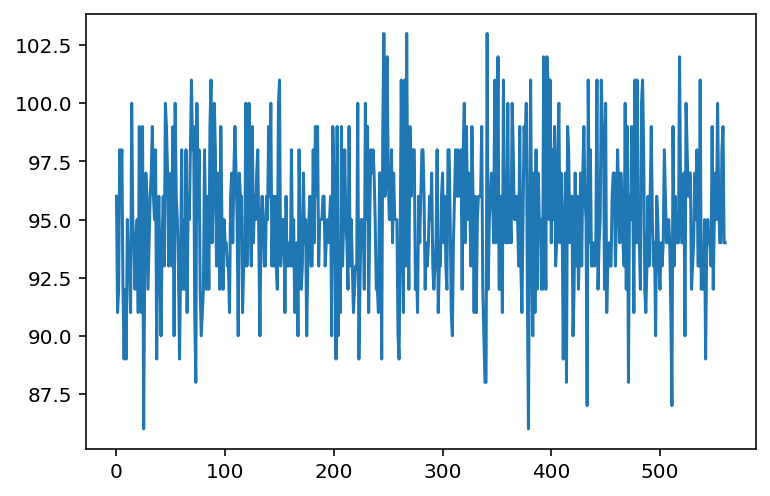

In [198]:
net.SGD(training_data=train_data, epochs=1, mini_batch_size=5, eta=0.5, plot_cost=True)

In [160]:
net.save("parameters")

In [319]:
def evaluate_accuracy(net_output, target_output):
    total = 0

    net_notes = NoteEmbedding.make_embedding(net_output)
    target_notes = NoteEmbedding.make_embedding(target_output)
    for x, y in zip(net_notes, target_notes):
        difference = abs(x.note_pitch - y.note_pitch)
        total += difference

    return total

In [325]:
accuracies = []
for n in range(200):
    untrained = extend_melody(validate_data[n][0], plot=False)
    accuracies.append(evaluate_accuracy(untrained, train_data[n][1]))

sum(accuracies)/len(accuracies)

494.14

In [322]:
net.scramble_parameters()